In [1]:
import torch
import torchvision
import torchvision.transforms as tr
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 파이토치 제공 데이터 사용

transf = tr.Compose([tr.Resize(16), tr.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transf)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transf)

print(trainset[0][0].size())

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
torch.Size([3, 16, 16])


In [3]:
trainloader = DataLoader(trainset, batch_size=50, shuffle=True)
testloader = DataLoader(testset, batch_size=50, shuffle=False)

len(trainloader)

1000

In [4]:
images, labels = next(iter(trainloader))
print(images.size())

torch.Size([50, 3, 16, 16])


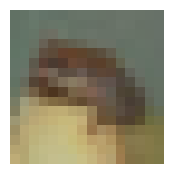

In [5]:
oneshot = images[1].permute(1, 2, 0).numpy()    # permute 함수를 통해 순서를 바꿔 채널을 마지막으로 옮김
plt.figure(figsize=(2, 2))  # 이미지 사이즈 조절
plt.imshow(oneshot) # 이미지 출력
plt.axis('off') # 축 제거
plt.show()  # 이미지 출력

In [6]:
# 같은 클래스 별로 폴더를 정리한 경우

# transf = tr.Compose([tr.Resize(128), tr.ToTensor()])
# trainset = torchvision.datasets.ImageFolder(root='./class', transform = transf)
# trainloader = DataLoader(trainset, batch_size = 1, shuffle = False)

In [7]:
# 정리되지 않은 커스텀 데이터 불러오기

train_images = np.random.randint(256, size=(100, 32, 32, 3))/255    # 32x32 크기의 랜덤 RGB 컬러 이미지 100개 생성
train_labels = np.random.randint(2, size=(100, 1))    # 100개의 랜덤 레이블 생성, 크기: 0~9

class TensorData(Dataset):
    
    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.x_data = self.x_data.permute(0, 3, 1, 2)
        # PyTorch에서는 이미지 데이터를 다룰 때 일반적으로 채널이 두 번째 차원에 위치
        # numpy는 채널이 마지막 차원에 위치
        self.y_data = torch.LongTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len

In [8]:
train_data = TensorData(train_images, train_labels)
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)

C:\Users\jwn63\AppData\Local\Temp\ipykernel_24764\920103660.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  active = int(np.random.randint(0, self.ratio, 1))
C:\Users\jwn63\AppData\Local\Temp\ipykernel_24764\920103660.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx = int(np.random.randint(0, min_len-box_size, 1))


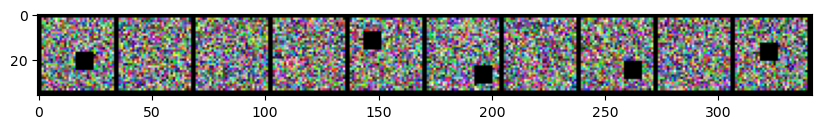

In [9]:
# 커스텀 데이터와 커스텀 전처리 사용하기기

class ToTensor:
    def __call__(self, sample):
        inputs, labels = sample
        inputs = torch.FloatTensor(inputs)
        inputs = inputs.permute(2, 0, 1)
        return inputs, torch.LongTensor(labels)
    
class CutOut:
    def __init__(self, ratio=0.5):
        self.ratio = int(1/ratio)
    
    def __call__(self, sample):
        inputs, labels = sample
        active = int(np.random.randint(0, self.ratio, 1))

        if active == 0:
            _, w, h = inputs.size()
            min_len = min(w, h)
            box_size = int(min_len//4)
            idx = int(np.random.randint(0, min_len-box_size, 1))
            inputs[:, idx:idx+box_size, idx:idx+box_size] = 0

        return inputs, labels

class MyDataset(Dataset):
    def __init__(self, x_data, y_data, transform=None):
        self.x_data = x_data
        self.y_data = y_data
        self.transform = transform
        self.len = len(y_data)
        self.tensor = ToTensor()

    def __getitem__(self, index):
        sample = (self.x_data[index], self.y_data[index])
        
        if self.transform:
            sample = self.transform(sample)
        else:
            sample = self.tensor(sample)
        
        return sample
    
    def __len__(self):
        return self.len

trans = tr.Compose([ToTensor(), CutOut()])
dataset1 = MyDataset(train_images, train_labels, transform = trans)
train_loader1 = DataLoader(dataset1, batch_size = 10, shuffle = True)

import torchvision
images1, labels1 = next(iter(train_loader1))

def imshow(img):
    plt.figure(figsize=(10, 100))
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.show()

imshow(torchvision.utils.make_grid(images1, nrow=10))


In [10]:
# 커스텀 데이터와 파이토치 제공 전처리 사용하기기

class MyTransform:

    def __call__(self, sample):
        inputs, labels = sample
        inputs = torch.FloatTensor(inputs)
        inputs = inputs.permute(2, 0, 1)
        labels = torch.FloatTensor(labels)

        transf = tr.Compose([tr.ToPILImage(), tr.Resize(128), tr.ToTensor()])
        final_output = transf(inputs)

        return final_output, labels

dataset2 = MyDataset(train_images, train_labels, transform = MyTransform())
train_loader2 = DataLoader(dataset2, batch_size = 10, shuffle = True)

Files already downloaded and verified


C:\Users\jwn63\AppData\Local\Temp\ipykernel_24764\1544369462.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  active = int(np.random.randint(0, self.ratio, 1))
C:\Users\jwn63\AppData\Local\Temp\ipykernel_24764\1544369462.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx = int(np.random.randint(0, min_len-box_size, 1))


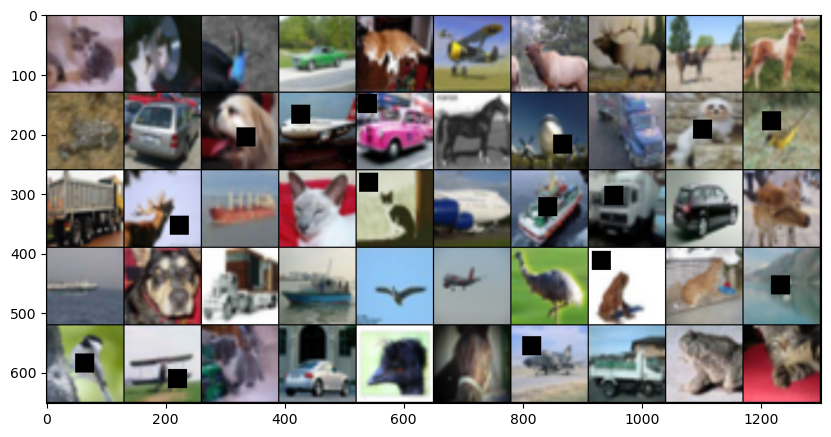

torch.Size([50, 3, 128, 128])


In [11]:
# 커스텀 전처리와 파이토치에서 제공하는 전처리 함께 사용하기기

class CutOut:
    def __init__(self, ratio=0.5):
        self.ratio = int(1/ratio)
    
    def __call__(self, inputs):
        active = int(np.random.randint(0, self.ratio, 1))

        if active == 0:
            _, w, h = inputs.size()
            min_len = min(w, h)
            box_size = int(min_len//4)
            idx = int(np.random.randint(0, min_len-box_size, 1))
            inputs[:, idx:idx+box_size, idx:idx+box_size] = 0

        return inputs

transf = tr.Compose([tr.Resize(128), tr.ToTensor(), CutOut()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transf)

trainloader = DataLoader(trainset, batch_size=50, shuffle=True)
images, labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images, nrow=10))
print(images.size())